In [80]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from tqdm.auto import tqdm

# Set style for the plots
plt.style.use('seaborn-v0_8')

In [2]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])
series = df.set_index('timestamp')['value'].asfreq('W')
series

timestamp
2000-01-02    239.42
2000-01-09    239.45
2000-01-16    239.03
2000-01-23    239.36
2000-01-30    239.98
               ...  
2025-03-23    242.51
2025-03-30    242.51
2025-04-06    242.32
2025-04-13    241.87
2025-04-20    241.43
Freq: W-SUN, Name: value, Length: 1321, dtype: float64

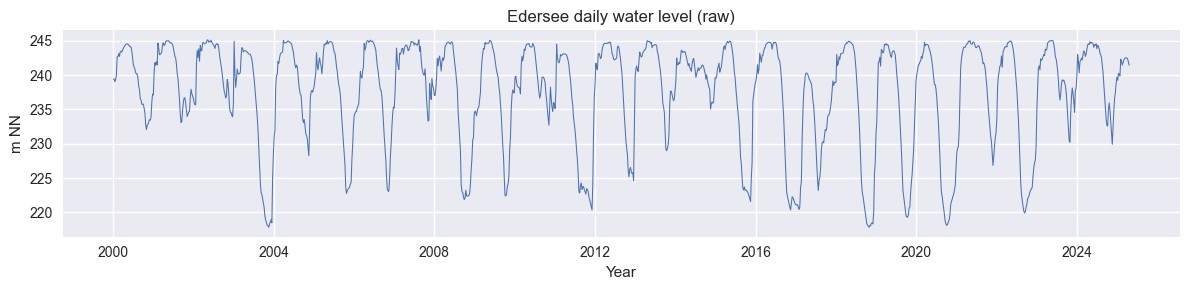

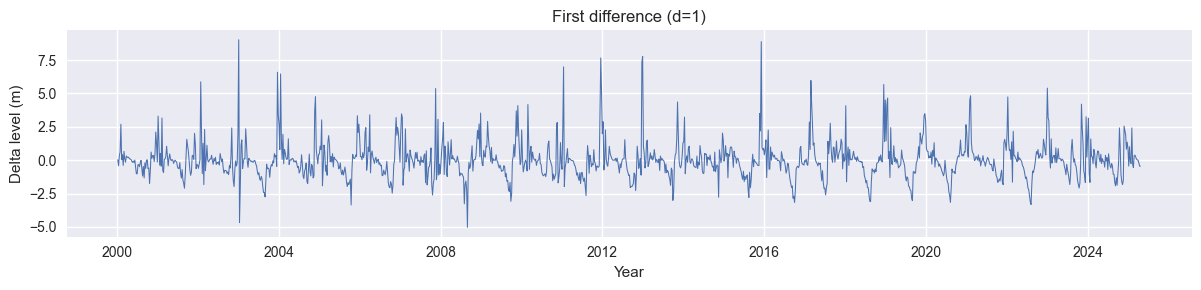

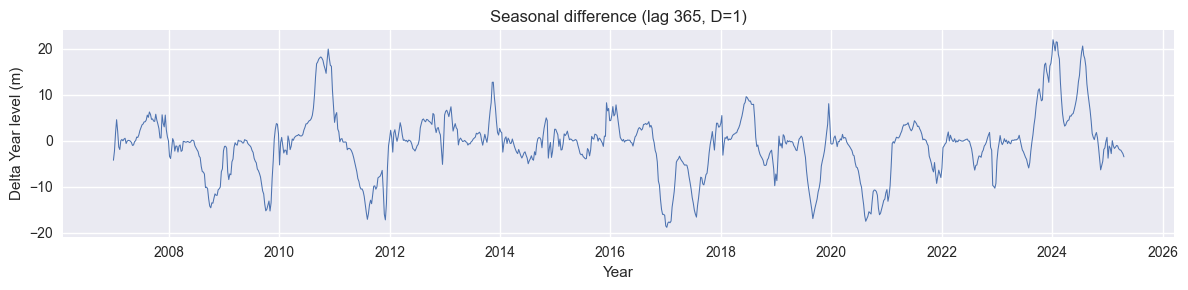

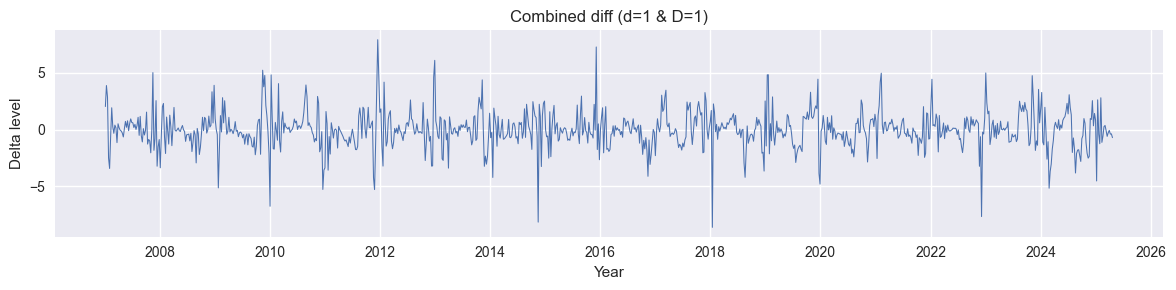

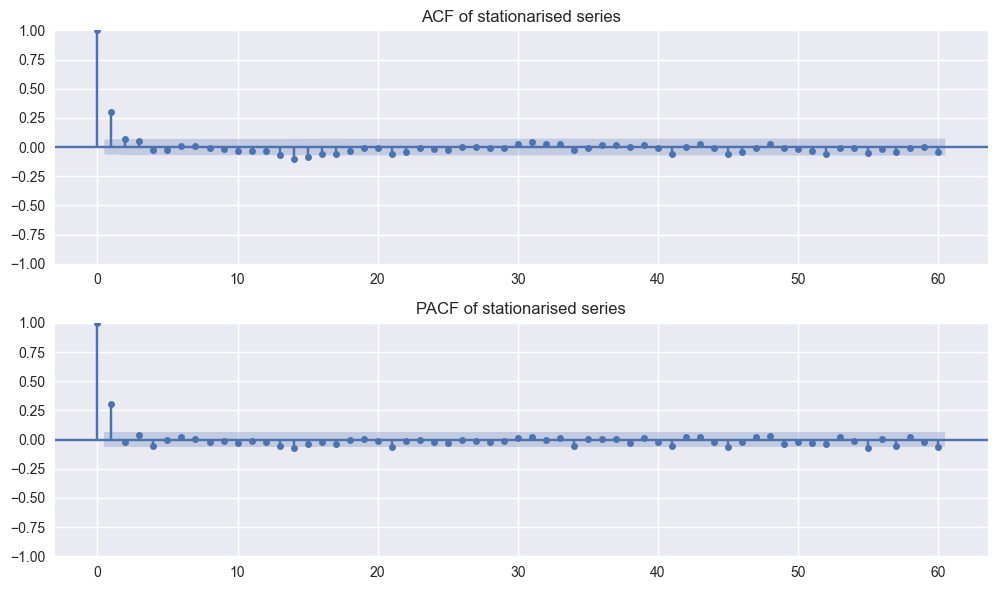

In [3]:
# ---- 1. Raw series ----
plt.figure(figsize=(12,3))
plt.plot(series, linewidth=0.75)
plt.title("Edersee daily water level (raw)")
plt.xlabel("Year")
plt.ylabel("m NN")
plt.tight_layout()
plt.show()

# ---- 2. Non‑seasonal diff (d=1) ----
d1 = series.diff().dropna()
plt.figure(figsize=(12,3))
plt.plot(d1, linewidth=0.75)
plt.title("First difference (d=1)")
plt.xlabel("Year")
plt.ylabel("Delta level (m)")
plt.tight_layout()
plt.show()

# ---- 3. Seasonal diff (lag 365, D=1) ----
D1 = series.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(D1, linewidth=0.75)
plt.title("Seasonal difference (lag 365, D=1)")
plt.xlabel("Year")
plt.ylabel("Delta Year level (m)")
plt.tight_layout()
plt.show()

# ---- 4. Combined diff ----
d1D1 = d1.diff(365).dropna()
plt.figure(figsize=(12,3))
plt.plot(d1D1, linewidth=0.75)
plt.title("Combined diff (d=1 & D=1)")
plt.xlabel("Year")
plt.ylabel("Delta level")
plt.tight_layout()
plt.show()

# ---- 5. ACF & PACF for combined diff ----
fig, ax = plt.subplots(2, 1, figsize=(10,6))
plot_acf(d1D1, ax=ax[0], lags=60)
plot_pacf(d1D1, ax=ax[1], lags=60, method='ywm')
ax[0].set_title("ACF of stationarised series")
ax[1].set_title("PACF of stationarised series")
plt.tight_layout()
plt.show()

In [4]:
adf_stat, adf_p, *_ = adfuller(series, autolag='AIC')
print(f'ADF Statistic: {adf_stat:.3f}')
print(f'p-value: {adf_p:.3f}')

ADF Statistic: -10.227
p-value: 0.000


# Single Model

In [5]:
# Train Validation Test split
train = series[:'2018-12-31']
valid = series['2019-01-01':'2021-12-31']
test = series['2022-01-01':]

In [65]:
model = SARIMAX(
    train,
    order=(1, 1, 0),
    seasonal_order=(1, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

print(model.summary())
resid = model.resid

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  992
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1617.700
Date:                            Sat, 26 Apr 2025   AIC                           3241.400
Time:                                    12:00:39   BIC                           3255.760
Sample:                                01-02-2000   HQIC                          3246.890
                                     - 12-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3315      0.018     18.815      0.000       0.297       0.366
ar.S.L52      -0.5126      0.018   

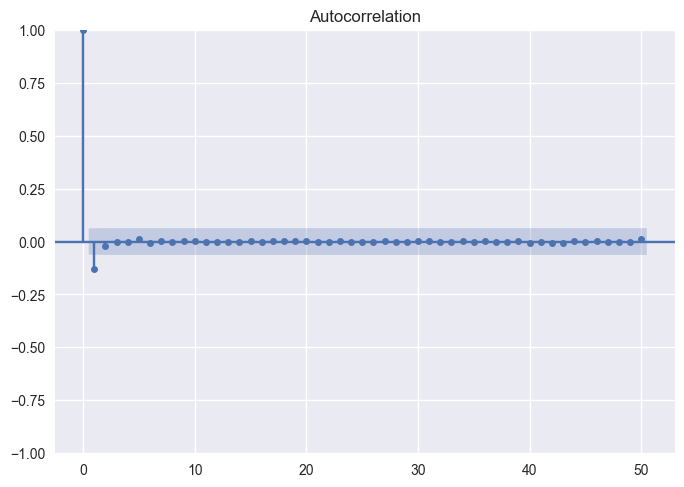

In [66]:
# Residual diagnostics
resid = model.resid
plot_acf(resid, lags=50)
plt.show()

In [68]:
acorr_ljungbox(resid, lags=[20,40], return_df=True)

,lb_stat,lb_pvalue
20,17.474922,0.621954
40,17.574564,0.999203


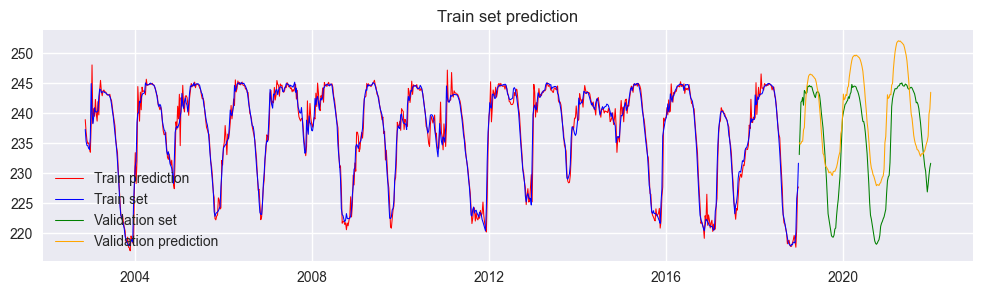

In [74]:
pred_train = model.predict(start=train.index[0], end=train.index[-1])
pred_valid = model.predict(start=valid.index[0], end=valid.index[-1])
plt.figure(figsize=(12,3))
plt.plot(pred_train[150:], color='red', linewidth=0.75, label='Train prediction')
plt.plot(train[150:], color='blue', linewidth=0.75, label='Train set')
plt.plot(valid, color='green', linewidth=0.75, label='Validation set')
plt.plot(pred_valid, color='orange', linewidth=0.75, label='Validation prediction')
plt.title("Train set prediction")
plt.legend()

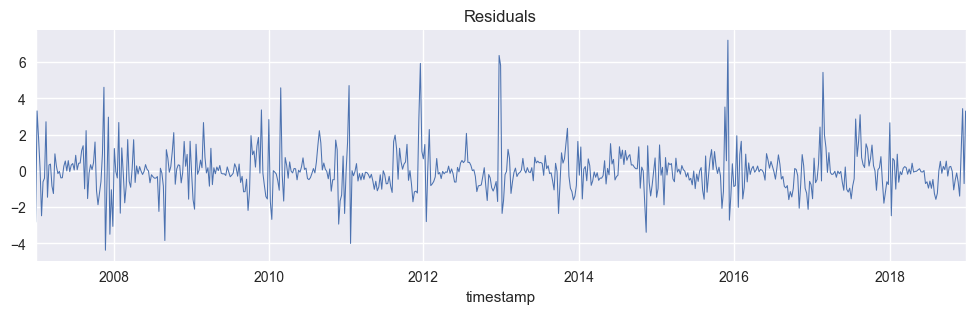

In [62]:
resid = model.resid
resid[365:].plot(title='Residuals', figsize=(12,3), linewidth=0.75)
plt.show()

In [70]:
pred = model.forecast(len(valid))
mae  = mean_absolute_error(valid, pred)
rmse = math.sqrt(mean_squared_error(valid, pred))
print(f"MAE = {mae:.2f}  RMSE = {rmse:.2f}")

MAE = 5.77  RMSE = 6.61


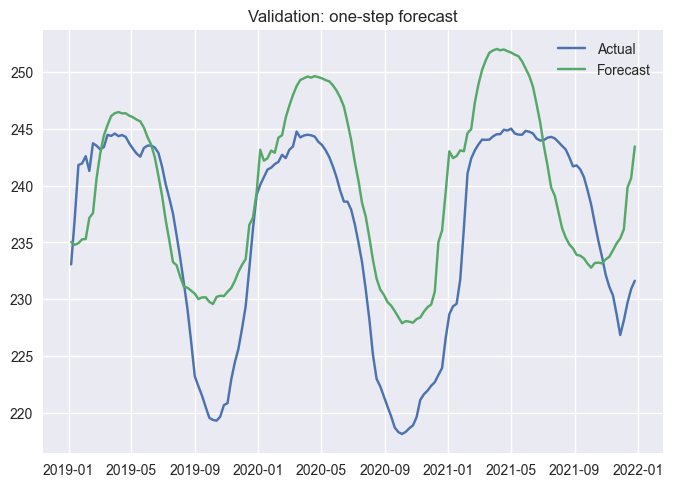

In [71]:
plt.plot(valid, label='Actual')
plt.plot(pred, label='Forecast')
plt.legend(); plt.title("Validation: one-step forecast"); plt.show()

# Rolling Window Approach

In [77]:
df = pd.read_csv('../data/processed/water_levels_daily.csv', parse_dates=['timestamp'])

In [ ]:
import warnings
import time
warnings.filterwarnings("ignore")

weekly = (df
          .set_index('timestamp')['value']
          .resample('W-SUN')           # weekly mean ending Sunday
          .mean()
          .interpolate())

# ---------- 2. Train / validation / test split ----------
train = weekly[:'2018-12-30']          # Sunday before 31‑12‑2018
valid = weekly['2019-01-06':'2021-12-26']   # full ISO weeks
# (test period not used here)

# ---------- 3. Rolling‑window forecast settings ----------
window_weeks = 2 * 52                  
order = (1, 1, 0)
seasonal_order = (0, 1, 0, 52)

pred_vals, ci_low, ci_high = [], [], []
valid_dates = valid.index

t0 = time.time()
for target_date in tqdm(valid_dates, desc="Rolling forecast"):
    # Define training window: 8 years before the target week
    train_end = target_date - pd.offsets.Week(1)
    train_start = train_end - pd.offsets.Week(window_weeks-1)
    train_window = weekly.loc[train_start:train_end]
    
    # Fit SARIMA on the rolling window
    res = SARIMAX(train_window,
                  order=order,
                  seasonal_order=seasonal_order,
                #   simple_differencing=True,
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)
    
    # One‑week‑ahead forecast for the target_date
    fc = res.get_forecast(steps=1)
    pred_vals.append(fc.predicted_mean.iloc[0])
    ci = fc.conf_int(alpha=0.05).iloc[0]
    ci_low.append(ci[0]); ci_high.append(ci[1])

elapsed = time.time() - t0

# ---------- 4. Assemble series ----------
rolling_pred = pd.Series(pred_vals, index=valid_dates)
ci_low = pd.Series(ci_low, index=valid_dates)
ci_high = pd.Series(ci_high, index=valid_dates)

Rolling forecast:   0%|          | 0/156 [00:00<?, ?it/s]

In [125]:
mae = mean_absolute_error(valid, rolling_pred)
rmse = math.sqrt(mean_squared_error(valid, rolling_pred))
metrics_df = pd.DataFrame({'Metric': ['MAE', 'RMSE'], 'Value': [mae, rmse]})
metrics_df

,Metric,Value
0,MAE,0.724453
1,RMSE,1.113100


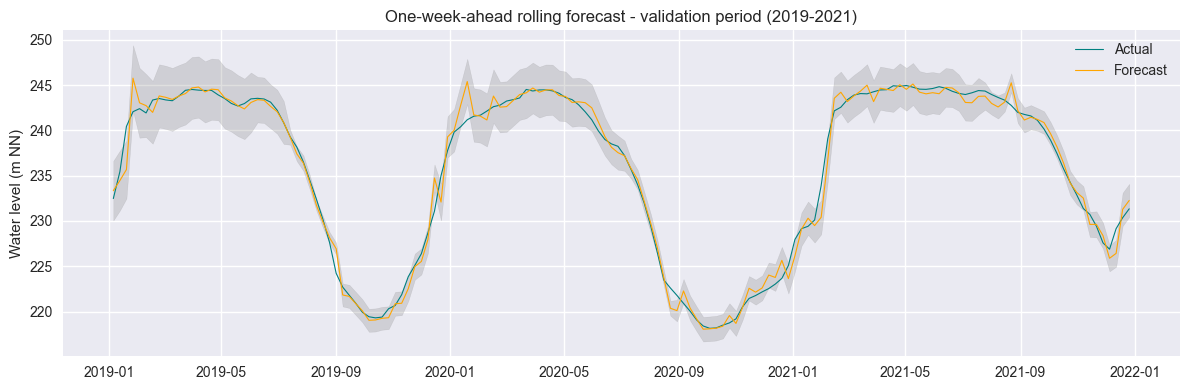

In [127]:
plt.figure(figsize=(12,4))
plt.plot(valid, label='Actual', color='teal', lw=.8)
plt.plot(rolling_pred, label='Forecast', color='orange', lw=.8)
plt.fill_between(valid_dates, ci_low, ci_high, color='gray', alpha=0.25)
plt.title("One-week-ahead rolling forecast - validation period (2019-2021)")
plt.ylabel("Water level (m NN)")
plt.legend()
plt.tight_layout()
plt.show()

,lb_stat,lb_pvalue
20,23.771957,0.252496
40,39.313299,0.500993


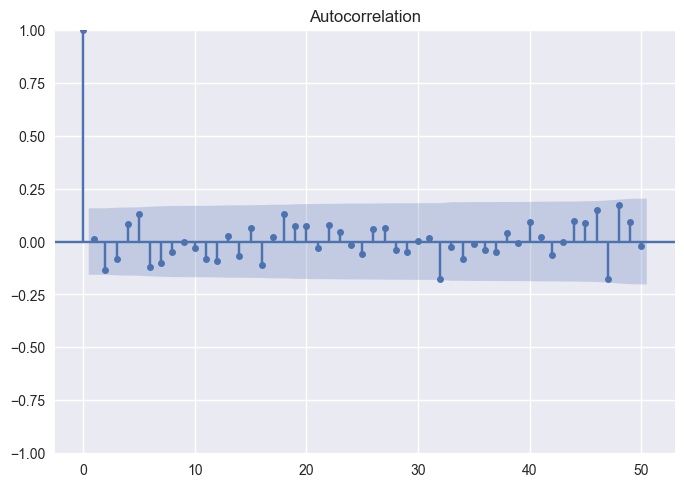

In [129]:
resid = valid - rolling_pred
plot_acf(resid, lags=50)
acorr_ljungbox(resid, lags=[20,40])